In [1]:
import yaml
from TraceSimulator import TraceSimulator
import numpy as np
import matplotlib.pyplot as plt

def read_yaml_to_dict(file_path):
    with open(file_path, 'r') as file:
        config_dict = yaml.safe_load(file)
    return config_dict

config = read_yaml_to_dict('config.yaml')
ts = TraceSimulator(config)

ModuleNotFoundError: No module named 'TraceSimulator'

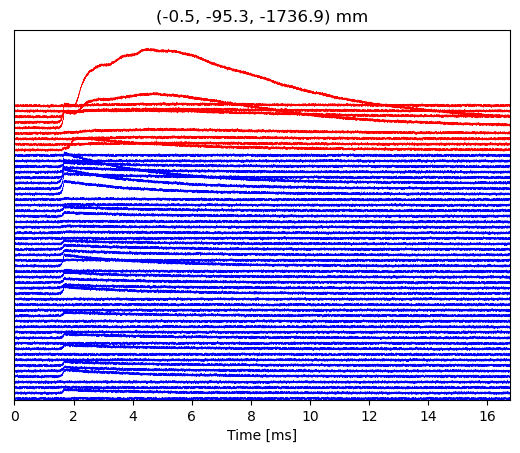

In [65]:
trace, (x, y, z) = ts.generate(5890, type_recoil='NR') 
times = 0.5 * (ts.t_edges[1:] + ts.t_edges[:-1])
for i in range(54):
    if i > 44:
        plt.plot(times * 1e-6, trace[0][i] + i * 50, c='r', lw=0.2)
    else:
        plt.plot(times * 1e-6, trace[0][i] + i * 50, c='b', lw=0.2)
        
plt.xlim(0, np.max(times * 1e-6)), plt.xlabel('Time [ms]')
plt.ylim(-10), plt.yticks([])
plt.title(f'({x[0]:.1f}, {y[0]:.1f}, {z[0]:.1f}) mm');

In [5]:
from numpy.fft import rfft, fft, ifft, fftfreq, rfftfreq
import numpy as np

def calculate_psd(traces, sampling_frequency=1.0):
    """Return the PSD of an n-dimensional array, assuming that we want the PSD of the last axis.
    Originally taken from https://github.com/spice-herald/QETpy/blob/master/qetpy/core/_noise.py
    
    Parameters
    ----------
    traces : array_like
        Array to calculate PSD of.
    sampling_frequency : float, optional
        Sample rate of the data being taken, assumed to be in units of Hz.
            
    Returns
    -------
    f : ndarray
        Array of sample frequencies
    psd : ndarray
        Power spectral density of traces. If traces are in units of A, then the PSD is in units of A^2/Hz.
        One can plot the psd with
            plt.loglog(f,psd)
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('PSD (A$^2$/Hz)')
            plt.show()
        
    """
    
    # calculate normalization for correct units
    norm = sampling_frequency * traces.shape[-1]

    # if folded_over = True, we calculate the Fourier Transform for only the positive frequencies
    if len(traces.shape)==1:
        psd = (np.abs(rfft(traces))**2.0)/norm
    else:
        psd = np.mean(np.abs(rfft(traces))**2.0, axis=0)/norm

    # multiply the necessary frequencies by two (zeroth frequency should be the same, as
    # should the last frequency when x.shape[-1] is odd)
    psd[1:traces.shape[-1]//2+1 - (traces.shape[-1]+1)%2] *= 2.0
    f = rfftfreq(traces.shape[-1], d=1.0/sampling_frequency)

    return f, psd

Saved PSDs for submerged and vacuum channels.


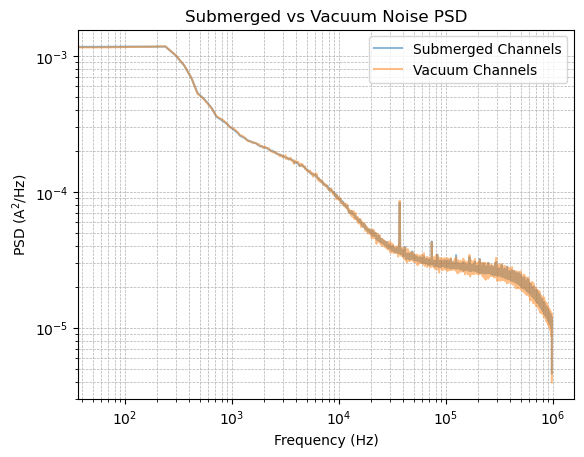

In [ ]:
trace, (x, y, z) = ts.generate(0, type_recoil='NR')
trace = trace.squeeze()  # shape becomes (54, 32768)
import numpy as np
import matplotlib.pyplot as plt

# Assume `traces` is a 2D array with shape (54, N), where:
# - First 45 rows are "submerged" channels
# - Last 9 rows are "vacuum" channels

sampling_frequency = 1953125.0

# Split the traces
submerged_traces = trace[:45]
vacuum_traces = trace[45:]

# Calculate PSDs
f_sub, psd_sub = calculate_psd(submerged_traces, sampling_frequency=sampling_frequency)
f_vac, psd_vac = calculate_psd(vacuum_traces, sampling_frequency=sampling_frequency)

# Save PSDs
np.save("noise_psd_submerged.npy", psd_sub)
np.save("noise_psd_vacuum.npy", psd_vac)
print("Saved PSDs for submerged and vacuum channels.")

# Plot both PSDs
plt.loglog(f_sub, psd_sub, label="Submerged Channels", alpha = 0.5)
plt.loglog(f_vac, psd_vac, label="Vacuum Channels", alpha = 0.5)
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD (A$^2$/Hz)")
plt.legend()
plt.title("Submerged vs Vacuum Noise PSD")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [48]:
trace = ts.generate(200, x=-40, y=80, z=-1800, no_noise=True, type_recoil='NR') 
trace = trace.squeeze(0)


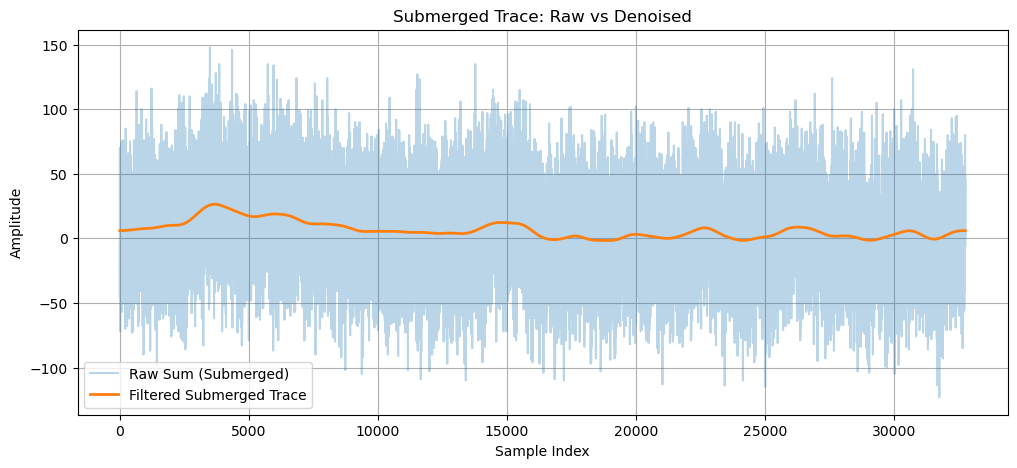

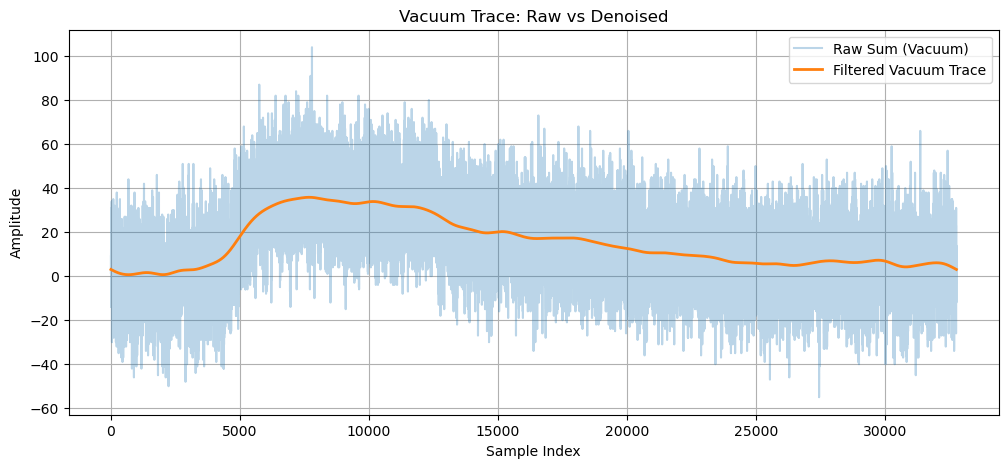

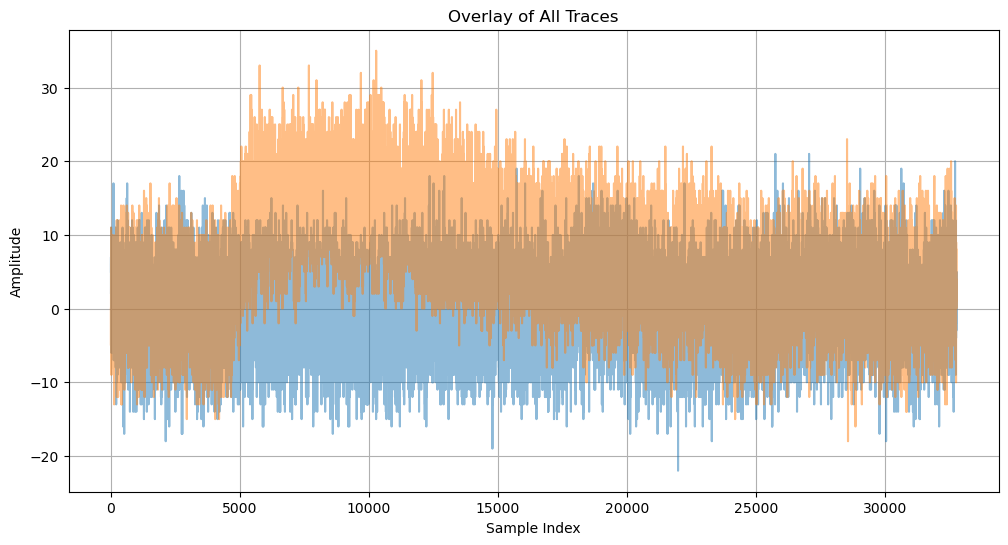

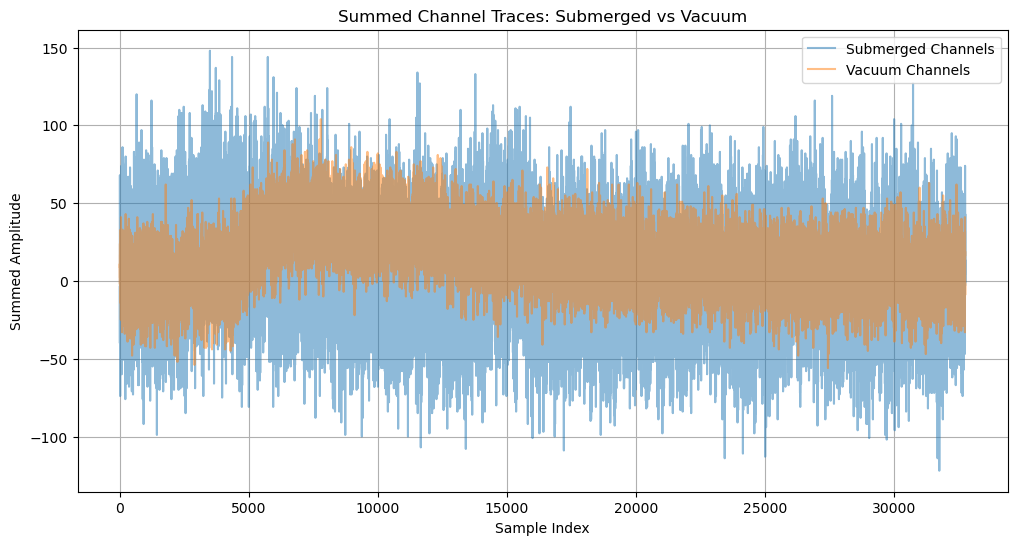

In [ ]:
from scipy.signal import welch

fs = 1953125.0  # Sampling frequency in Hz (adjust if known)
N = trace.shape[1]

# Step 1: Sum of submerged channels (0–40)
sum_submerged = np.sum(trace[:45], axis=0)

# Step 2: Estimate PSD from noise (use pre-bump region)
pre_bump = sum_submerged[:2048]  # assume first 10k samples are noise
freqs, psd = welch(pre_bump, fs=fs, window='hann', nperseg=2048)

# Step 3: FFT of the submerged trace
freqs_full = np.fft.rfftfreq(N, 1/fs)
signal_fft_sub = np.fft.rfft(sum_submerged)

# Step 4: Interpolate PSD to match FFT length
psd_interp = np.interp(freqs_full, freqs, psd)

# Step 5: Apply PSD-based filter with frequency cutoff (submerged)
cutoff_freq = 2000  # Hz, adjust based on signal bandwidth
filter_mask = freqs_full < cutoff_freq
filtered_fft_sub = np.where(filter_mask, signal_fft_sub / psd_interp, 0)
filtered_fft_sub *= np.abs(signal_fft_sub[0]) / np.abs(filtered_fft_sub[0])  # normalize
filtered_trace_sub = np.fft.irfft(filtered_fft_sub, n=N)

# Step 6: Sum of vacuum channels (41–50)
sum_vacuum = np.sum(trace[45:], axis=0)
signal_fft_vac = np.fft.rfft(sum_vacuum)

# Step 7: Apply PSD-based filter with frequency cutoff (vacuum)
filtered_fft_vac = np.where(filter_mask, signal_fft_vac / psd_interp, 0)
filtered_fft_vac *= np.abs(signal_fft_vac[0]) / np.abs(filtered_fft_vac[0])  # normalize
filtered_trace_vac = np.fft.irfft(filtered_fft_vac, n=N)

# Step 8: Plot submerged trace separately
plt.figure(figsize=(12, 5))
plt.plot(sum_submerged, label='Raw Sum (Submerged)', alpha=0.3)
plt.plot(filtered_trace_sub, label='Filtered Submerged Trace', linewidth=2)
plt.title('Submerged Trace: Raw vs Denoised')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

# Step 9: Plot vacuum trace separately
plt.figure(figsize=(12, 5))
plt.plot(sum_vacuum, label='Raw Sum (Vacuum)', alpha=0.3)
plt.plot(filtered_trace_vac, label='Filtered Vacuum Trace', linewidth=2)
plt.title('Vacuum Trace: Raw vs Denoised')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(12, 6))
for i in [range(trace.shape[0])]:
    plt.plot(trace[i], alpha=0.5)
plt.title('Overlay of All Traces')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

# Plot 2: Sum of submerged vs vacuum channels
sum_submerged = np.sum(trace[0:44], axis=0)  # Channels 0-40
sum_vacuum = np.sum(trace[44:], axis=0)    # Channels 41-50

plt.figure(figsize=(12, 6))
plt.plot(sum_submerged, label='Submerged Channels', alpha=0.5)
plt.plot(sum_vacuum, label='Vacuum Channels', alpha=0.5)
plt.title('Summed Channel Traces: Submerged vs Vacuum')
plt.xlabel('Sample Index')
plt.ylabel('Summed Amplitude')
plt.legend()
plt.grid(True)
plt.show()


In [10]:
x

array([-38.67754856])

In [11]:
y

array([76.88987585])

In [12]:
z

array([-1727.33581177])

((-10.0, 2813.6964227846056), ([], []))

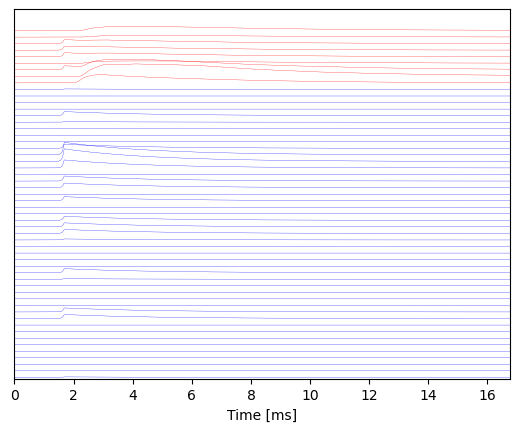

In [14]:
trace = ts.generate(2000, x=-30, y=60, z=-1800, no_noise=True, type_recoil='NR', quantize=False) 
trace = trace.squeeze(0)
times = 0.5 * (ts.t_edges[1:] + ts.t_edges[:-1])
for i in range(54):
    if i > 44:
        plt.plot(times * 1e-6, trace[i] + i * 50, c='r', lw=0.2)
    else:
        plt.plot(times * 1e-6, trace[i] + i * 50, c='b', lw=0.2)
        
plt.xlim(0, np.max(times * 1e-6)), plt.xlabel('Time [ms]')
plt.ylim(-10), plt.yticks([])


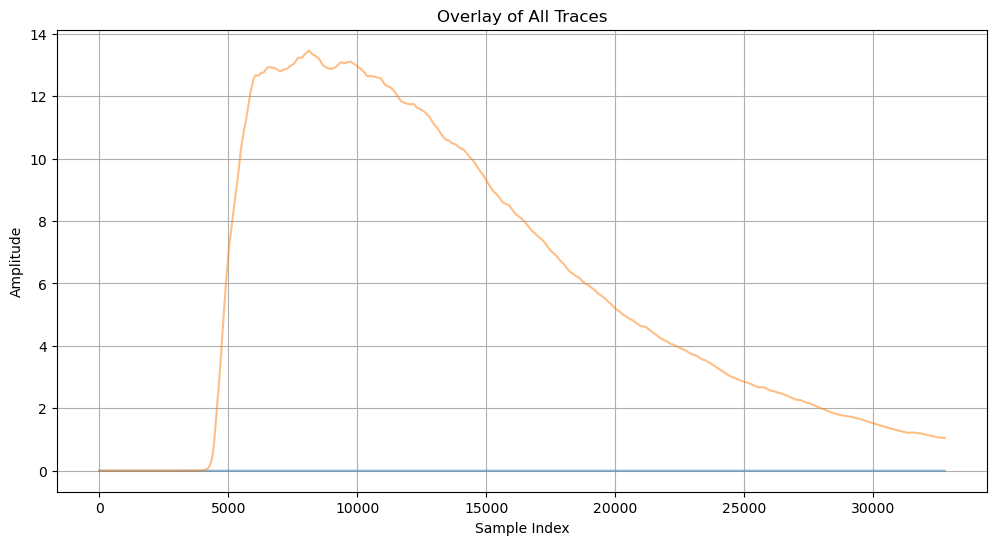

In [69]:
trace = ts.generate(200, x=-30, y=60, z=-1800, no_noise=True, type_recoil='NR', quantize=False) 
trace = trace.squeeze(0)
plt.figure(figsize=(12, 6))
for i in [40,  46]:
    plt.plot(trace[i], alpha=0.5)
plt.title('Overlay of All Traces')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

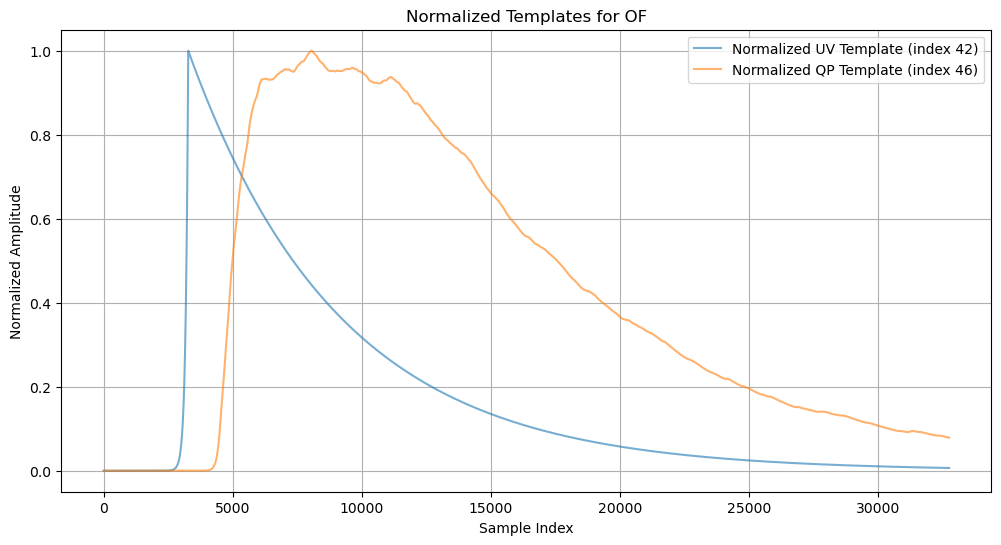

In [162]:
import numpy as np
import matplotlib.pyplot as plt

# Extract traces
uv_template = trace[42]
qp_template = trace[46]

# Normalize templates (by max absolute value)
uv_template_norm = uv_template / np.max(np.abs(uv_template))
qp_template_norm = qp_template / np.max(np.abs(qp_template))

# Save as .npy files
np.save("template_uv.npy", uv_template_norm)
np.save("template_qp.npy", qp_template_norm)

# Optional: Plot to verify
plt.figure(figsize=(12, 6))
plt.plot(uv_template_norm, label="Normalized UV Template (index 42)", alpha=0.6)
plt.plot(qp_template_norm, label="Normalized QP Template (index 46)", alpha=0.6)
plt.title('Normalized Templates for OF')
plt.xlabel('Sample Index')
plt.ylabel('Normalized Amplitude')
plt.legend()
plt.grid(True)
plt.show()


In [1]:
import numpy as np

positionMMC = np.loadtxt('/ceph/bmaier/delight/share/TraceSimulator/position_MMC.dat')


In [2]:
positionMMC.shape

(54, 4)

In [7]:
print(positionMMC)

[[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 -1.9530000e+03]
 [ 1.0000000e+00  9.8000000e+01  0.0000000e+00 -1.9530000e+03]
 [ 2.0000000e+00  6.9296460e+01  6.9296460e+01 -1.9530000e+03]
 [ 3.0000000e+00  0.0000000e+00  9.8000000e+01 -1.9530000e+03]
 [ 4.0000000e+00 -6.9296460e+01  6.9296460e+01 -1.9530000e+03]
 [ 5.0000000e+00 -9.8000000e+01  0.0000000e+00 -1.9530000e+03]
 [ 6.0000000e+00 -6.9296460e+01 -6.9296460e+01 -1.9530000e+03]
 [ 7.0000000e+00 -0.0000000e+00 -9.8000000e+01 -1.9530000e+03]
 [ 8.0000000e+00  6.9296460e+01 -6.9296460e+01 -1.9530000e+03]
 [ 1.0000000e+03  1.4000000e+02  0.0000000e+00 -1.9160000e+03]
 [ 1.0010000e+03  1.2124356e+02  7.0000000e+01 -1.9160000e+03]
 [ 1.0020000e+03  7.0000000e+01  1.2124356e+02 -1.9160000e+03]
 [ 1.0030000e+03  0.0000000e+00  1.4000000e+02 -1.9160000e+03]
 [ 1.0040000e+03 -7.0000000e+01  1.2124356e+02 -1.9160000e+03]
 [ 1.0050000e+03 -1.2124356e+02  7.0000000e+01 -1.9160000e+03]
 [ 1.0060000e+03 -1.4000000e+02  0.0000000e+00 -1.91600